## Shape Analysis w/ BF Correction

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_14/conda/envs/lsst-scipipe-3.0.0-ext/eups 	setup
lsst_distrib          g4eaec17cb9+23bdaa02ee 	w_latest w_2022_14 current setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
import logging


logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import Analyzer, readData, getSensorData

#### Read Data

In [5]:
outdir = "/sdf/home/a/abrought/run5/BF/data/"
data_uncorrected = readData( outdir + "data_13250_R24_S11_2022-06-08T20:10:35_ellipse_680nm_uncorrected.pkl", \
                 expstoremove=0)
data_corrected = readData( outdir + "data_13250_R24_S11_2022-06-08T20:29:54_ellipse_680nm_corrected.pkl", \
                 expstoremove=0)

File 1
5.0s, 40 images
10.0s, 40 images
15.0s, 40 images
20.0s, 40 images
25.0s, 40 images
30.0s, 40 images
35.0s, 40 images
40.0s, 40 images
45.0s, 40 images
50.0s, 40 images
File 1
5.0s, 40 images
10.0s, 40 images
15.0s, 40 images
20.0s, 40 images
25.0s, 40 images
30.0s, 40 images
35.0s, 40 images
40.0s, 40 images
45.0s, 40 images
50.0s, 40 images


## Main Plot

In [7]:
ptc_turnoffs, cti_turnoffs, mos, gains, gains_linearized, _ = getSensorData(sensor="R24_S11", detector=112)




Text(0.5, 1.0, 'R24-S11')

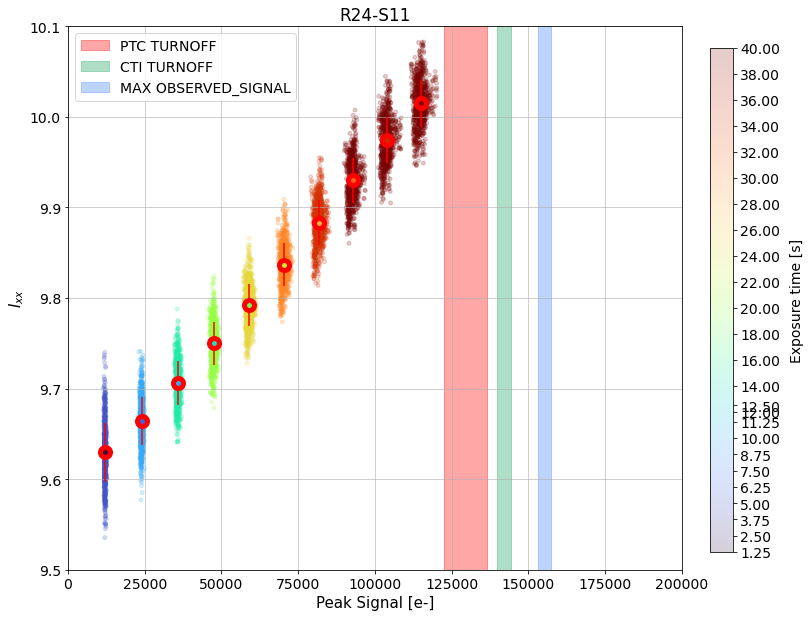

In [8]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
data = data_uncorrected
exptimes = np.unique(data['exptime'])
#ref = data_corr[np.where(data_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="peakSignal"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in data))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in data:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.35, color='red', label = "PTC TURNOFF")
ax.axvspan(np.min(cti_turnoffs), np.max(cti_turnoffs), alpha=0.35, color='#1aa260', label = "CTI TURNOFF")
ax.axvspan(np.min(mos), np.max(mos), alpha=0.35, color='#4285F4', label = "MAX OBSERVED_SIGNAL")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []

for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    fitx.append(aggregated.x)
    fity.append(aggregated.y)
        
    for spec in [1]:
        sca3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

    


ax.set_ylabel("{}".format("$I_{xx}$"),fontsize=15)
ax.set_xlabel("Peak Signal [e-]", fontsize=15, y=-10)
ax.set_xlim(0,200000)
#ax.set_ylim(4.5,6.0)
ax.set_ylim(9.5,10.1)
#ax.set_ylim(.05,.45)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)
m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
#plt.text(10000.,5.30,"{}".format(r"Slope $I_{xx}$ (corrected) = ") + "\n" + str(round(slope,4)) +"% per 10k e-", fontsize=16)

#ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="red" , linestyle="--")
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R24-S11")
#plt.savefig("../plots/Ixx-corrected-R24_S11.png", bbox_inches='tight')

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_14/conda/envs/lsst-scipipe-3.0.0-ext/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 1.0, 'R24-S11')

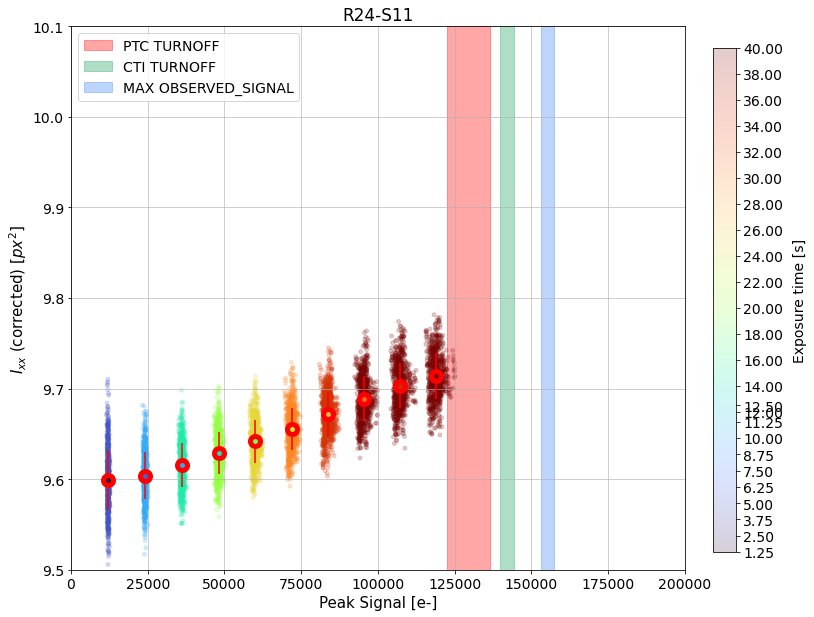

In [9]:
from astropy.stats import mad_std

class Aggregated:
    pass
    
data = data_corrected
exptimes = np.unique(data['exptime'])
#ref = data_corr[np.where(data_corr['exptime'] == 6.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="peakSignal"
#xkey = "base_PsfFlux_instFlux"
#xkey="base_CircularApertureFlux_25_0_instFlux"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"

fontsize=14
T0s = []

# Find all spots common to all images
from functools import reduce
spots_to_track = reduce(np.intersect1d, tuple(i['spot_indices'] for i in data))


x = []
y = []
IxxErrs = []
IyyErrs = []
IxyErrs = []
ixx = []
iyy = []
zl = []
zs = []
e = []
exps = []
amps = []
for iterable in data:
    index = np.argwhere(exptimes==iterable['exptime'])[0][0]

    x.extend(iterable[xkey])
    Y1=iterable[y1key]
    Y2=iterable[y2key]
    amps.extend(iterable["amps"])
    y.extend( Y1 )
    IxxErrs.extend(iterable["base_SdssShape_xxErr"])
    IyyErrs.extend(iterable["base_SdssShape_yyErr"])
    IxyErrs.extend(iterable["base_SdssShape_xyErr"])
    ixx.extend(iterable["base_SdssShape_xx"])
    iyy.extend(iterable["base_SdssShape_yy"])
    
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
IxxErrs = np.array(IxxErrs)
IyyErrs = np.array(IyyErrs)
IxyErrs = np.array(IxyErrs)
ixx = np.array(ixx)
iyy = np.array(iyy)
e = np.array(e)
amps = np.array(amps)
#print(e[0], y[np.where((e==e[0])&(y!=0))].std())

n = len(set(e))-1


# Plot

fig = plt.figure(figsize=(11,10), facecolor='w')
ax = plt.subplot(111)

# Plot the min and max ptc turnoffs for this sensor
ax.axvspan(np.min(ptc_turnoffs), np.max(ptc_turnoffs), alpha=0.35, color='red', label = "PTC TURNOFF")
ax.axvspan(np.min(cti_turnoffs), np.max(cti_turnoffs), alpha=0.35, color='#1aa260', label = "CTI TURNOFF")
ax.axvspan(np.min(mos), np.max(mos), alpha=0.35, color='#4285F4', label = "MAX OBSERVED_SIGNAL")

array_aggregated = []

xs_stderrs = []
ys = []
es = []
stderrs_lowestexp = []
errofstderr_lowestexp = []
xxErrs = []
yyErrs = []
xyErrs = []
ixxs = []
iyys = []
properrs = []

fitx = []
fity = []

for j, i in enumerate(exptimes):
    
    import matplotlib
    normalize = matplotlib.colors.Normalize(vmin=1.25, vmax=40)

    cond = np.argwhere((e==i)&(y!=0))
    sca=ax.scatter(x[cond],y[cond],c=e[cond], cmap='turbo', norm=normalize, s=15, alpha=0.2)
    
    num = len(x[cond])
    from astropy.stats import bootstrap
    #errofstderr_lowestexp.append(bootstrap(y[cond], bootnum=100, bootfunc=np.std))
    
    aggregated = Aggregated()
    aggregated.e = np.mean(i)   
    aggregated.x = np.mean(x[cond])
    aggregated.y = np.mean(y[cond])
    aggregated.xerr = np.std(x[cond])
    aggregated.yerr = np.std(y[cond])
    
    xxErrs.append(np.median(IxxErrs[cond]))
    yyErrs.append(np.median(IyyErrs[cond]))
    xyErrs.append(np.median(IxyErrs[cond]))
    ixxs.append(np.median(ixx[cond]))
    iyys.append(np.median(iyy[cond]))

    
    stderrs_lowestexp.append(aggregated.yerr)
    xs_stderrs.append(aggregated.x)
    aggregated.num = num
    aggregated.color = plt.get_cmap('turbo')((j)/n)
    array_aggregated.append(aggregated)
    
    if i <= 12. and i > 6:
        fitx.append(aggregated.x)
        fity.append(aggregated.y)
        
    for spec in [1]:
        sca3=ax.errorbar(aggregated.x,aggregated.y*spec,
                        xerr=aggregated.xerr,
                        yerr=aggregated.yerr,
                        fmt="o",color=aggregated.color,mec="r",ecolor="r",alpha=1,
                        ms=10,mew=5)

    


ax.set_ylabel("{}".format("$I_{xx}$ (corrected) $[px^{2}]$"),fontsize=15)
ax.set_xlabel("Peak Signal [e-]", fontsize=15, y=-10)
ax.set_xlim(0,200000)
#ax.set_ylim(4.5,6.0)
ax.set_ylim(9.5,10.1)
#ax.set_ylim(.05,.45)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.rcParams.update({'font.size': fontsize})

ax.grid(alpha=0.75)
m, b  = np.polyfit(fitx, fity, 1)
slope = m*100*1000
#plt.text(10000.,5.30,"{}".format(r"Slope $I_{yy}$ (corrected) = ") + "\n" + str(round(slope,4)) +"% per 10k e-", fontsize=16)

#ax.plot(np.linspace(0,5.5e6, 1000), m*np.linspace(0,5.5e6, 1000) + b, color="red" , linestyle="--")
x1 = np.linspace(0,5.5e6, 1000)
y1 = m*np.linspace(0,5.5e6, 1000) + b



#for ch in [90595.07, 118279.234] :
#        ax.axvline(ch, c="k", ls="-", alpha=0.75, label="Low/High Max obs. signal")
plt.legend(loc=2)
        
#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.935, 0.15, 0.03, 0.7])
cb = plt.colorbar(sca,cax=cbar_ax, ticks=[1.25,2.5,3.75,5.0,6.25,7.5,8.75,10.0,11.25,12.0,12.5,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0,32.0,34.0,36.0,38.0,40.0])


sca.set_clim(1.25,40)
cb.set_label("Exposure time [s]", labelpad=10)
plt.subplots_adjust(right=0.90,hspace=0)
ax.set_title("R24-S11")
#plt.savefig("../plots/Iyy-corrected-R24_S11.png", bbox_inches='tight')

### Difference in spot shape

In [10]:
fluxes = []
de = []
e_uncorrected = []
e_corrected = []
theta = []
thetas_uncorrected = []
thetas_corrected = []
As = []
Bs = []
A_uncorrected = []
B_uncorrected = []
A_corrected = []
B_corrected = []

for exp_uncorrected in data_uncorrected:
    if len(np.where(data_corrected["SEQNUM"] == exp_uncorrected["SEQNUM"])) ==0:
        continue
    
    exp_corrected = data_corrected[np.where(data_corrected["SEQNUM"] == exp_uncorrected["SEQNUM"])]
    
    for uncorr_index, index in enumerate(exp_uncorrected['spot_indices']):
        corr_index = np.argwhere(exp_corrected['spot_indices'].data[0] == index)
        if len(corr_index) == 0:
            continue

        theta_corrected = exp_corrected['theta'].data[0][corr_index[0]][0]
        a_corrected = exp_corrected['a'].data[0][corr_index[0]][0]
        b_corrected = exp_corrected['b'].data[0][corr_index[0]][0]
        g1 = exp_corrected['base_SdssShape_xx'].data[0][corr_index]-exp_corrected['base_SdssShape_yy'].data[0][corr_index]
        g2 = 2*exp_corrected['base_SdssShape_xy'].data[0][corr_index]
        ellipticity_corrected = np.sqrt(g1**2 + g2**2)
        
        theta_uncorrected = exp_uncorrected['theta'][uncorr_index]
        a_uncorrected = exp_uncorrected['a'][uncorr_index]
        b_uncorrected = exp_uncorrected['b'][uncorr_index]
        g1 = exp_uncorrected['base_SdssShape_xx'][uncorr_index]-exp_uncorrected['base_SdssShape_yy'][uncorr_index]
        g2 = 2*exp_uncorrected['base_SdssShape_xy'][uncorr_index]
        ellipticity_uncorrected = np.sqrt(g1**2 + g2**2)
        
        temp = (ellipticity_corrected - ellipticity_uncorrected) / ellipticity_uncorrected
        e_uncorrected.append(ellipticity_uncorrected)
        e_corrected.append(ellipticity_corrected)
        de.append(temp[0][0])
        fluxes.append(exp_uncorrected["peakSignal"][uncorr_index])
        thetas_uncorrected.append(theta_uncorrected)
        thetas_corrected.append(theta_corrected)
        theta.append((theta_corrected - theta_uncorrected)/theta_uncorrected)
        
        As.append((a_corrected - a_uncorrected)/a_uncorrected)
        Bs.append((b_corrected - b_uncorrected)/b_uncorrected)
        A_uncorrected.append(a_uncorrected)
        B_uncorrected.append(b_uncorrected)
        A_corrected.append(a_corrected)
        B_corrected.append(b_corrected)
        

(-0.01, 0.01)

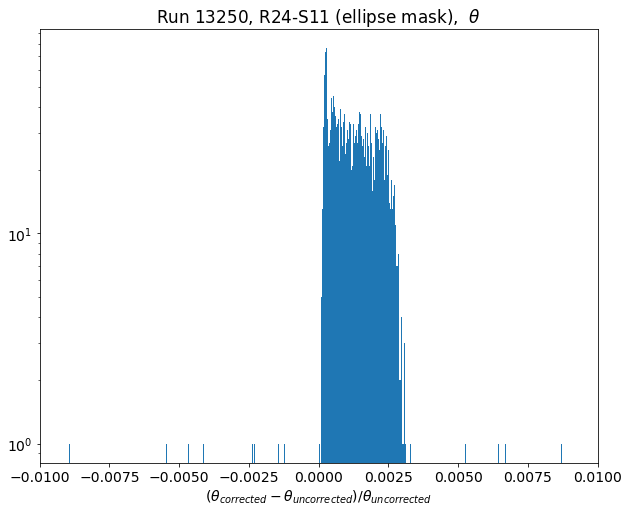

In [14]:
plt.figure(figsize=(10,8))
plt.title(r'Run 13250, R24-S11 (ellipse mask),  $\theta$')
theta = np.asarray(theta)
thetas_uncorrected = np.asarray(thetas_uncorrected)

mask = (theta > -0.01) & (theta < 0.01)
h = plt.hist(theta[mask], bins=1000, log=True)

plt.xlabel(r'$(\theta_{corrected} - \theta_{uncorrected}) / \theta_{uncorrected}$')
plt.xlim(-0.01,0.01)

(-0.01, 0.01)

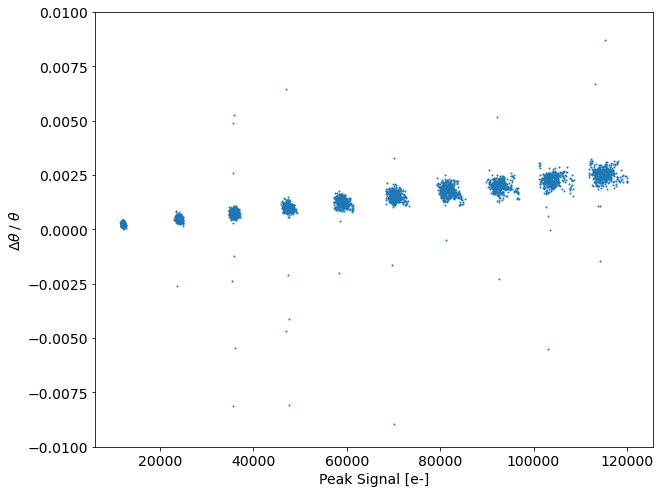

In [20]:
plt.figure(figsize=(10,8))
#plt.title(r'Run 13250, R24-S11 (ellipse mask),  $e = \sqrt{(I_{xx} - I_{yy})^{2} + (2I_{xy})^{2}}$')
h = plt.scatter(fluxes, theta, s=1)
plt.xlabel(r'Peak Signal [e-]')
plt.ylabel(r'$\Delta\theta\;/\;\theta$')
# r'$(\theta_{corrected} - \theta_{uncorrected}) / \theta_{uncorrected}$')
plt.ylim(-0.01,0.01)



(-0.02, 0.005)

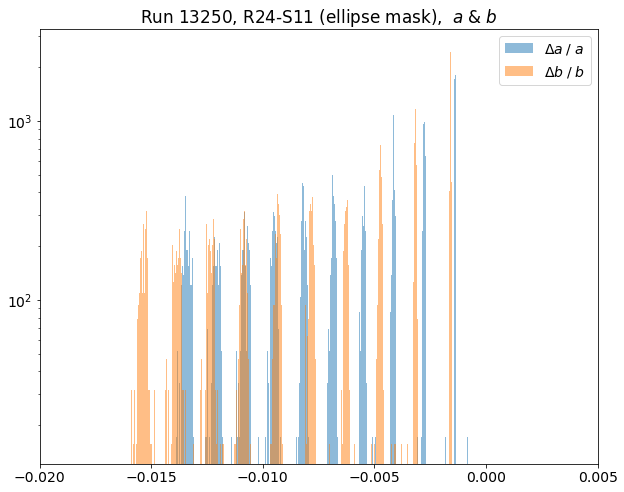

In [28]:
plt.figure(figsize=(10,8))
plt.title(r'Run 13250, R24-S11 (ellipse mask),  $a\;&\;b$')
theta = np.asarray(theta)
thetas_uncorrected = np.asarray(thetas_uncorrected)

#mask = (theta > -1) & (theta < 1)
h = plt.hist(As, bins=1000, density=True, log=True, label=r'$\Delta a\;/\;a$', alpha=0.5)
h = plt.hist(Bs, bins=1000, density=True, log=True, label=r'$\Delta b\;/\;b$', alpha=0.5)

#plt.xlabel(r'$(\theta_{corrected} - \theta_{uncorrected}) / \theta_{uncorrected}$')
plt.legend()
plt.xlim(-0.02,0.005)

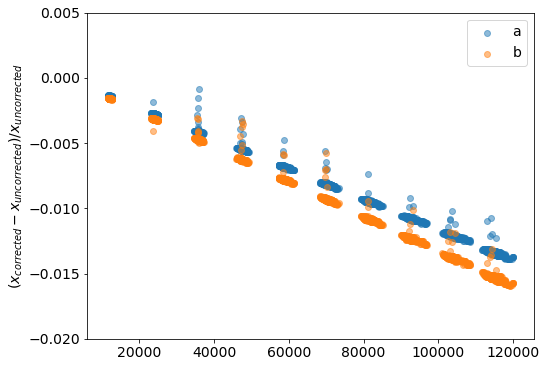

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(fluxes, As, label='a', alpha=0.5)
plt.scatter(fluxes, Bs, label='b', alpha=0.5)
plt.ylabel(r'$(x_{corrected} - x_{uncorrected}) / x_{uncorrected}$')
plt.ylim(-0.02,0.005)
plt.legend()